In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


/Users/tim/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


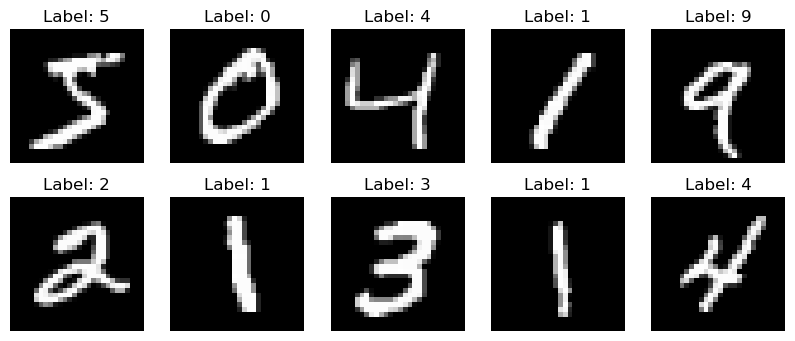

In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib.ticker as ticker

# Check if mps is available
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
# Convert data and target to numpy arrays
data = mnist.data
target = mnist.target.astype(np.uint8)  # convert labels from string to integer

# Split into training and testing sets
train_imgs = data[:60000]
train_labels = target[:60000]
test_imgs = data[60000:]
test_labels = target[60000:]

# Visualize the first 10 images and labels
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_imgs[i].reshape(28, 28), cmap='gray')
    ax.set_title("Label: {}".format(train_labels[i]))  # Use slicing train_labels[:10] to get first 10 labels
    ax.axis('off')

plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/img.png")

plt.show()

# Convert numpy arrays to PyTorch tensors
train_imgs = torch.from_numpy(train_imgs).float()
train_labels = torch.from_numpy(train_labels)
test_imgs = torch.from_numpy(test_imgs).float()
test_labels = torch.from_numpy(test_labels)

# Normalize the images to [-1, 1]
train_imgs = train_imgs / 255. * 2 - 1
test_imgs = test_imgs / 255. * 2 - 1


# Create data loaders
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1)



Training with learning rate: 0.0001
Epoch 1, Accuracy: 89.04%
Epoch 2, Accuracy: 90.61%
Epoch 3, Accuracy: 91.25%
Epoch 4, Accuracy: 91.85%
Epoch 5, Accuracy: 92.32%
Epoch 6, Accuracy: 92.73%
Epoch 7, Accuracy: 92.88%
Epoch 8, Accuracy: 93.25%
Epoch 9, Accuracy: 93.46%
Epoch 10, Accuracy: 93.54%
Epoch 11, Accuracy: 93.87%
Epoch 12, Accuracy: 93.95%
Epoch 13, Accuracy: 93.99%
Epoch 14, Accuracy: 94.15%
Epoch 15, Accuracy: 94.23%
Epoch 16, Accuracy: 94.44%
Epoch 17, Accuracy: 94.69%
Epoch 18, Accuracy: 94.82%
Epoch 19, Accuracy: 94.72%
Epoch 20, Accuracy: 94.97%
Epoch 21, Accuracy: 95.1%
Epoch 22, Accuracy: 95.27%
Epoch 23, Accuracy: 95.23%
Epoch 24, Accuracy: 95.37%
Epoch 25, Accuracy: 95.52%
Epoch 26, Accuracy: 95.54%
Epoch 27, Accuracy: 95.83%
Epoch 28, Accuracy: 95.84%
Epoch 29, Accuracy: 95.87%
Epoch 30, Accuracy: 95.85%
Epoch 31, Accuracy: 96.01%
Epoch 32, Accuracy: 96.11%
Epoch 33, Accuracy: 96.21%
Epoch 34, Accuracy: 96.2%
Epoch 35, Accuracy: 96.22%
Epoch 36, Accuracy: 96.33%
Epo

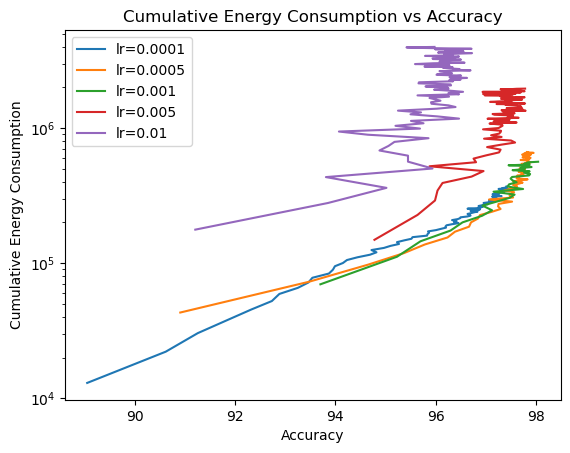

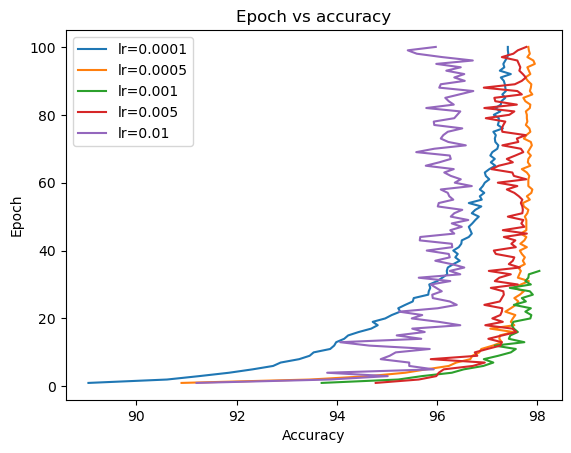

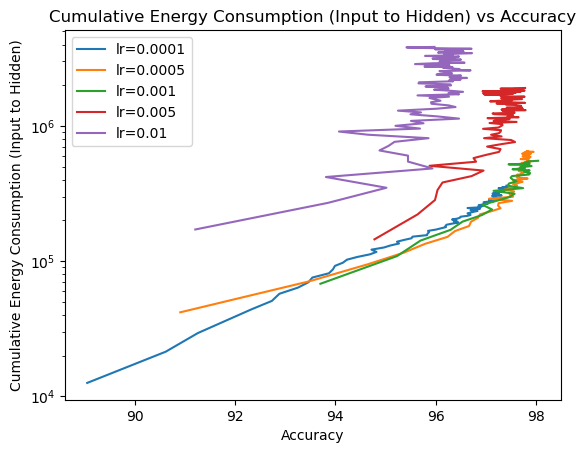

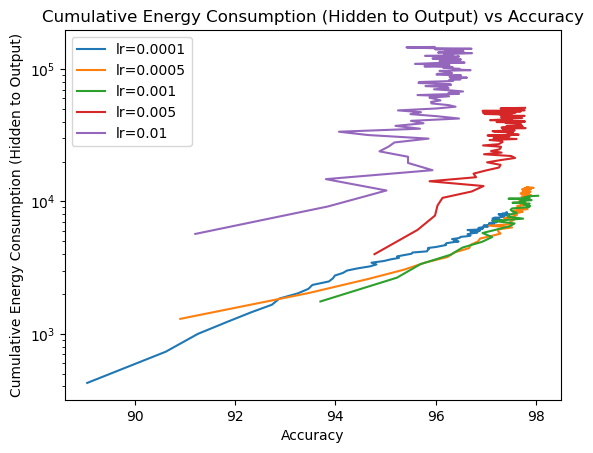

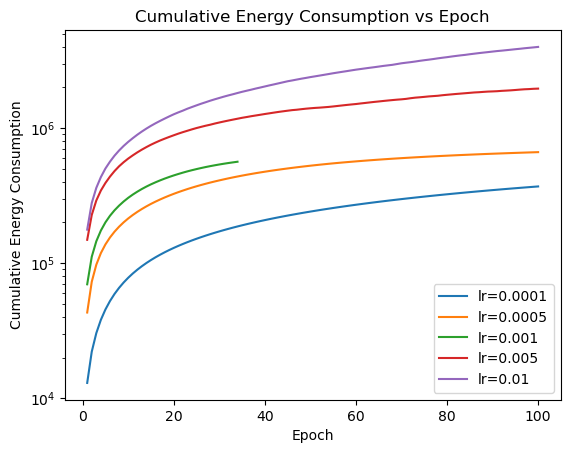

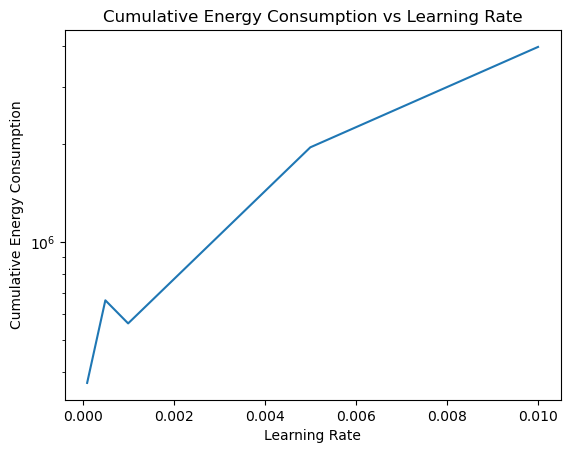

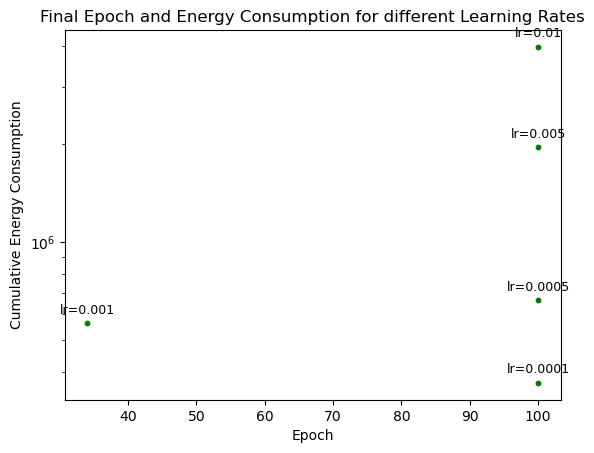

In [30]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

        # Xavier initialization
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

final_epochs = []
final_energy_consumptions = []
learning_rates = [0.0001, 0.0005, 0.001,0.005,0.01]
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    model = FFNN(input_dim, hidden_dim, output_dim)
    # Move the model to GPU if available
    #model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    cumulative_energy_consumption_input_to_hidden = 0
    cumulative_energy_consumption_hidden_to_output = 0
    energy_consumptions_input_to_hidden = []
    energy_consumptions_hidden_to_output = []
    

    for epoch in range(epochs):
        energy_consumption = 0
        energy_consumption_input_to_hidden = 0 
        energy_consumption_hidden_to_output = 0 
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            #images = images.to(device)
            #labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
    
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
            energy_consumption_input_to_hidden += weight_updates[0].abs().sum().item() + weight_updates[1].abs().sum().item()  # L1 norm for input to hidden
            energy_consumption_hidden_to_output += weight_updates[2].abs().sum().item() + weight_updates[3].abs().sum().item()  # L1 norm for hidden to output

        cumulative_energy_consumption += energy_consumption
        cumulative_energy_consumption_input_to_hidden += energy_consumption_input_to_hidden
        cumulative_energy_consumption_hidden_to_output += energy_consumption_hidden_to_output
        energy_consumptions.append(cumulative_energy_consumption)
        energy_consumptions_input_to_hidden.append(cumulative_energy_consumption_input_to_hidden)
        energy_consumptions_hidden_to_output.append(cumulative_energy_consumption_hidden_to_output)
        
        
        
        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 98:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    final_epochs.append(len(accuracies))
    final_energy_consumptions.append(cumulative_energy_consumption)
    
    plt.figure(1) 
    plt.semilogy(accuracies, energy_consumptions, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy')
    plt.legend()
    plt.figure(2)  
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()
    plt.figure(3)
    plt.semilogy(accuracies, energy_consumptions_input_to_hidden, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Input to Hidden)')
    plt.title('Cumulative Energy Consumption (Input to Hidden) vs Accuracy')
    plt.legend()
    plt.figure(4)
    plt.semilogy(accuracies, energy_consumptions_hidden_to_output, label=f'lr={lr}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Hidden to Output)')
    plt.title('Cumulative Energy Consumption (Hidden to Output) vs Accuracy')
    plt.legend()
    plt.figure(5)
    plt.semilogy(range(1, len(accuracies) + 1), energy_consumptions, label=f'lr={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Epoch')
    plt.legend()
   
    
    
  

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/learningrate_energy_vs_accuracy.png")

plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/learningrate_epochs_vs_accuracy.png")


plt.figure(3)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/lr_input_to_hidden.png")


plt.figure(4)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/lr_hidden_to_output.png")

plt.figure(5)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/learningrate_energy_vs_epoch.png")

plt.figure(6)
plt.semilogy(learning_rates, final_energy_consumptions)
plt.xlabel('Learning Rate')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Learning Rate')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/learningrate_vs_energy.png")

plt.figure(7)
plt.scatter(final_epochs, final_energy_consumptions, color='green', s=10)
for i, txt in enumerate(learning_rates):
    plt.annotate(f'lr={txt}', 
                 (final_epochs[i], final_energy_consumptions[i]),
                 fontsize=9, 
                 ha='center', 
                 va='bottom', 
                 xytext=(0,5), 
                 textcoords='offset points')
plt.xlabel('Epoch')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Final Epoch and Energy Consumption for different Learning Rates')
plt.yscale('log')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/lr_vs_epoch_energy_scatter.png")


plt.show()


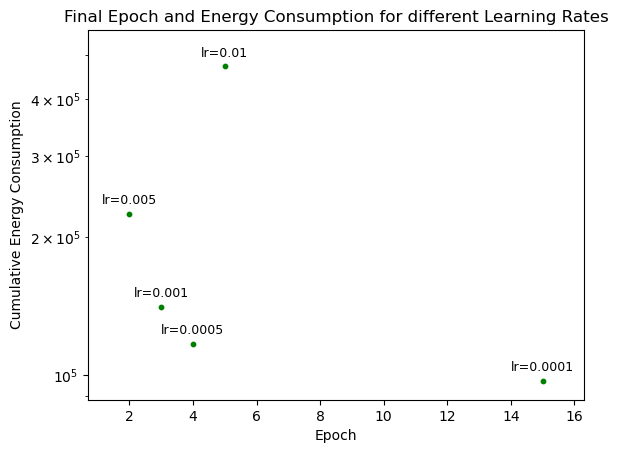

In [29]:
plt.figure(7)
plt.scatter(final_epochs, final_energy_consumptions, color='green', s=10)
for i, txt in enumerate(learning_rates):
    plt.annotate(f'lr={txt}', 
                 (final_epochs[i], final_energy_consumptions[i]),
                 fontsize=9, 
                 ha='center', 
                 va='bottom', 
                 xytext=(0,5), 
                 textcoords='offset points')
# Adjust the x and y axis limits
padding_x = 0.1 * (max(final_epochs) - min(final_epochs))
padding_y = 0.1 * (max(final_energy_consumptions) - min(final_energy_consumptions))
plt.xlim(min(final_epochs) - padding_x, max(final_epochs) + padding_x)
plt.ylim(min(final_energy_consumptions) / 1.1, max(final_energy_consumptions) * 1.2)  # For log scale, use division and multiplication
plt.xlabel('Epoch')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Final Epoch and Energy Consumption for different Learning Rates')
plt.yscale('log')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/lr_vs_epoch_energy_scatter.png")


plt.show()

In [ ]:
import time
# Check if mps is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        nn.init.xavier_normal_(self.layers[-1].weight)  # Xavier initialization for input layer

        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            nn.init.xavier_normal_(self.layers[-1].weight)  # Xavier initialization for hidden layers

        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        nn.init.xavier_normal_(self.layers[-1].weight)  # Xavier initialization for output layer

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x



# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes
    
# Check if mps is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define the structure variations
width_variations = [100, 1000, 5000, 10000]
lr=0.001

start_time = time.time()
final_energy_consumptions = []
# Fixed depth, vary width
for hidden_dim in width_variations:
    print(f'Training with hidden_dim={hidden_dim}, num_layers=1')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, hidden_dim, output_dim, 1)
    # Move the model to GPU if available
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    cumulative_energy_consumption_input_to_hidden = 0
    cumulative_energy_consumption_hidden_to_output = 0
    energy_consumptions_input_to_hidden = []
    energy_consumptions_hidden_to_output = []
    epochs_list = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        energy_consumption_input_to_hidden = 0 
        energy_consumption_hidden_to_output = 0 
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
            energy_consumption_input_to_hidden += weight_updates[0].abs().sum().item() + weight_updates[1].abs().sum().item()  # L1 norm for input to hidden
            energy_consumption_hidden_to_output += weight_updates[2].abs().sum().item() + weight_updates[3].abs().sum().item()  # L1 norm for hidden to output

        cumulative_energy_consumption += energy_consumption
        cumulative_energy_consumption_input_to_hidden += energy_consumption_input_to_hidden
        cumulative_energy_consumption_hidden_to_output += energy_consumption_hidden_to_output
        energy_consumptions.append(cumulative_energy_consumption)
        energy_consumptions_input_to_hidden.append(cumulative_energy_consumption_input_to_hidden)
        energy_consumptions_hidden_to_output.append(cumulative_energy_consumption_hidden_to_output)
        


        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 98:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    final_energy_consumptions.append(cumulative_energy_consumption)       
    plt.figure(1)        
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim={hidden_dim}, num_layers=1')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed depth, vary width)')
    plt.legend()
    plt.figure(2)  
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim={hidden_dim}, num_layers=1')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()
    plt.figure(3)
    plt.semilogy(accuracies, energy_consumptions_input_to_hidden, label=f'hidden_dim={hidden_dim}, num_layers=1')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Input to Hidden)')
    plt.title('Cumulative Energy Consumption (Input to Hidden) vs Accuracy')
    plt.legend()
    plt.figure(4)
    plt.semilogy(accuracies, energy_consumptions_hidden_to_output, label=f'hidden_dim={hidden_dim}, num_layers=1')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption (Hidden to Output)')
    plt.title('Cumulative Energy Consumption (Hidden to Output) vs Accuracy')
    plt.legend()
    


plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidthaccuracy_over_epochs.png")

plt.figure(3)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidthinput_to_hidden.png")


plt.figure(4)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varywidthhidden_to_output.png")

plt.figure(5)
plt.semilogy(width_variations, final_energy_consumptions)
plt.xlabel('Width')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Width')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/width_vs_energy.png")
plt.show()



end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 94.0%
Epoch 2, Accuracy: 95.1%
Epoch 3, Accuracy: 95.52%
Epoch 4, Accuracy: 96.18%
Epoch 5, Accuracy: 96.6%
Epoch 6, Accuracy: 96.97%
Epoch 7, Accuracy: 96.97%
Epoch 8, Accuracy: 97.12%
Epoch 9, Accuracy: 97.26%
Epoch 10, Accuracy: 97.31%
Epoch 11, Accuracy: 96.98%
Epoch 12, Accuracy: 97.02%
Epoch 13, Accuracy: 97.45%
Epoch 14, Accuracy: 97.54%
Epoch 15, Accuracy: 97.58%
Epoch 16, Accuracy: 97.56%
Epoch 17, Accuracy: 97.53%
Epoch 18, Accuracy: 97.41%
Epoch 19, Accuracy: 97.71%
Epoch 20, Accuracy: 97.35%
Epoch 21, Accuracy: 97.12%
Epoch 22, Accuracy: 97.66%
Epoch 23, Accuracy: 97.69%
Epoch 24, Accuracy: 97.47%
Epoch 25, Accuracy: 97.68%
Epoch 26, Accuracy: 97.86%
Epoch 27, Accuracy: 97.67%
Epoch 28, Accuracy: 97.59%
Epoch 29, Accuracy: 97.6%
Epoch 30, Accuracy: 97.59%
Epoch 31, Accuracy: 97.54%
Epoch 32, Accuracy: 97.63%
Epoch 33, Accuracy: 97.49%
Epoch 34, Accuracy: 97.78%
Epoch 35, Accuracy: 97.57%
Epoch 36, Accuracy: 97.9%

Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 87.83%
Epoch 2, Accuracy: 89.87%
Epoch 3, Accuracy: 90.71%
Epoch 4, Accuracy: 91.24%
Epoch 5, Accuracy: 91.76%
Epoch 6, Accuracy: 92.21%
Epoch 7, Accuracy: 92.46%
Epoch 8, Accuracy: 92.82%
Epoch 9, Accuracy: 92.84%
Epoch 10, Accuracy: 93.14%
Epoch 11, Accuracy: 93.49%
Epoch 12, Accuracy: 93.62%
Epoch 13, Accuracy: 93.64%
Epoch 14, Accuracy: 94.17%
Epoch 15, Accuracy: 94.34%
Epoch 16, Accuracy: 94.43%
Epoch 17, Accuracy: 94.64%
Epoch 18, Accuracy: 94.79%
Epoch 19, Accuracy: 94.85%
Epoch 20, Accuracy: 95.02%
Stopping training after reaching 95.02% accuracy.
Training with hidden_dim=100, num_layers=3
Epoch 1, Accuracy: 77.48%
Epoch 2, Accuracy: 87.34%
Epoch 3, Accuracy: 89.51%
Epoch 4, Accuracy: 90.52%
Epoch 5, Accuracy: 91.55%
Epoch 6, Accuracy: 91.78%
Epoch 7, Accuracy: 92.56%
Epoch 8, Accuracy: 92.78%
Epoch 9, Accuracy: 93.36%
Epoch 10, Accuracy: 93.7%
Epoch 11, Accuracy: 94.13%
Epoch 12, Accuracy: 94.33%
Epoch 13, Accuracy:

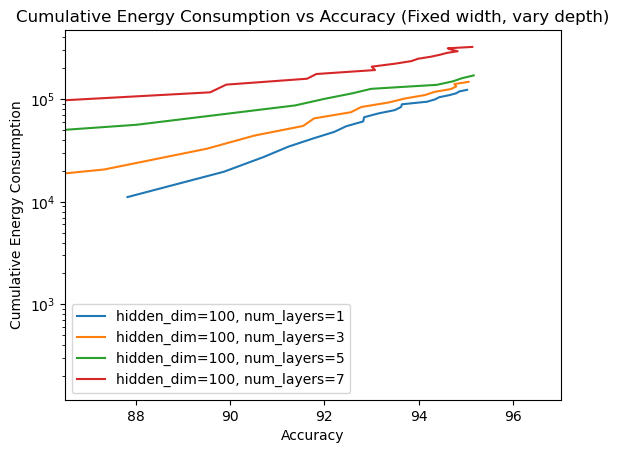

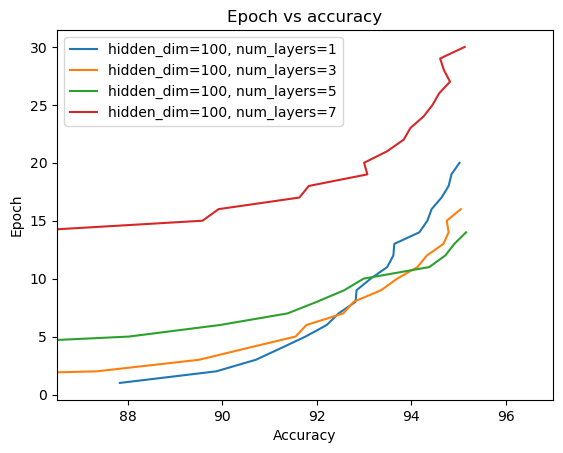

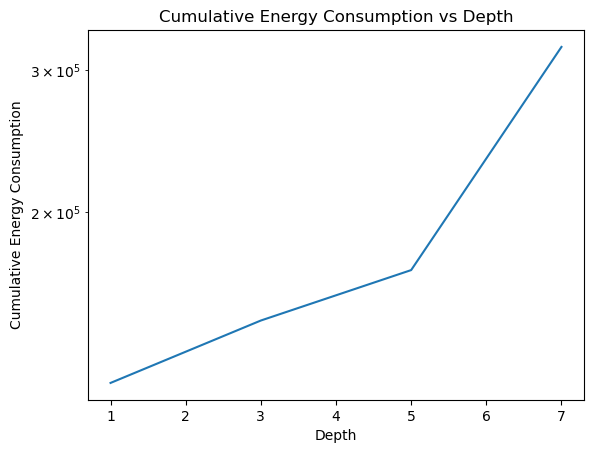

Elapsed time: 2929.951815843582 seconds


In [3]:
import time
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x
# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

depth_variations = [1, 3, 5, 7]
lr=0.0001
start_time = time.time()
final_energy_consumptions = []
# Fixed width, vary depth
for num_layers in depth_variations:
    print(f'Training with hidden_dim=100, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, 100, output_dim, num_layers)
    # Move the model to GPU if available
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    cumulative_energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)
        cumulative_energy_consumptions.append(cumulative_energy_consumption)


        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    final_energy_consumptions.append(cumulative_energy_consumption) 
    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim=100, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
    plt.xlim(86.5, 97)  # Set the x-axis limits
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim=100, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.xlim(86.5, 97)  # Set the x-axis limits
    plt.legend()


plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthaccuracy_over_epochs.png")

plt.figure(3)
plt.semilogy(depth_variations, final_energy_consumptions)
plt.xlabel('Depth')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Depth')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/depth_vs_energy.png")

plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")



In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 打開已保存的圖片
img_without_skip = mpimg.imread("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthaccuracy_over_epochs.png")
img_with_skip = mpimg.imread("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/used/resdepth")

# 創建一個新的figure
plt.figure(figsize=(10, 6))

# 顯示兩張圖片
plt.imshow(img_without_skip, alpha=0.5, label="Without Skip Connection")
plt.imshow(img_with_skip, alpha=0.5, label="With Skip Connection")

# 添加legend
plt.legend()

# 保存合併後的圖片
plt.savefig("/path/to/save/combined/image.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/used/resdepth'

In [ ]:
plt.figure(3)
plt.semilogy(depth_variations, final_energy_consumptions)
plt.xlabel('Depth')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Depth')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/depth_vs_energy.png")

plt.show()

print(depth_variations)
print(final_energy_consumptions)

Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 87.99%
Epoch 2, Accuracy: 90.09%
Epoch 3, Accuracy: 90.75%
Epoch 4, Accuracy: 91.4%
Epoch 5, Accuracy: 91.57%
Epoch 6, Accuracy: 92.08%
Epoch 7, Accuracy: 92.37%
Epoch 8, Accuracy: 92.5%
Epoch 9, Accuracy: 93.05%
Epoch 10, Accuracy: 93.17%
Epoch 11, Accuracy: 93.6%
Epoch 12, Accuracy: 93.6%
Epoch 13, Accuracy: 93.93%
Epoch 14, Accuracy: 94.07%
Epoch 15, Accuracy: 94.41%
Epoch 16, Accuracy: 94.47%
Epoch 17, Accuracy: 94.52%
Epoch 18, Accuracy: 94.88%
Epoch 19, Accuracy: 94.97%
Epoch 20, Accuracy: 94.96%
Epoch 21, Accuracy: 95.08%
Stopping training after reaching 95.08% accuracy.
Training with hidden_dim=100, num_layers=3
Epoch 1, Accuracy: 88.33%
Epoch 2, Accuracy: 89.97%
Epoch 3, Accuracy: 90.67%
Epoch 4, Accuracy: 91.18%
Epoch 5, Accuracy: 91.32%
Epoch 6, Accuracy: 91.42%
Epoch 7, Accuracy: 91.76%
Epoch 8, Accuracy: 91.86%
Epoch 9, Accuracy: 91.92%
Epoch 10, Accuracy: 92.14%
Epoch 11, Accuracy: 92.24%
Epoch 12, Accuracy: 92

KeyboardInterrupt: 

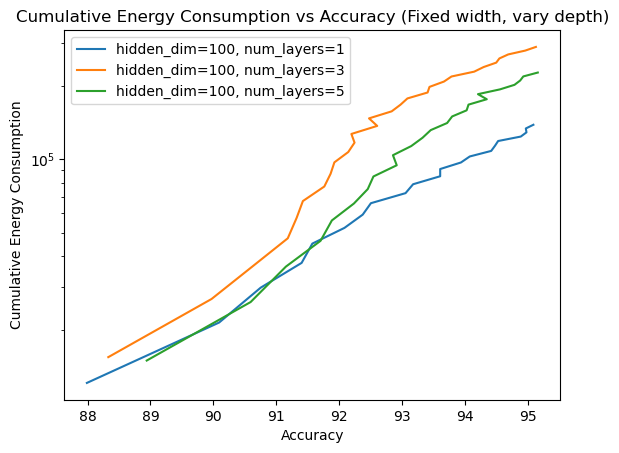

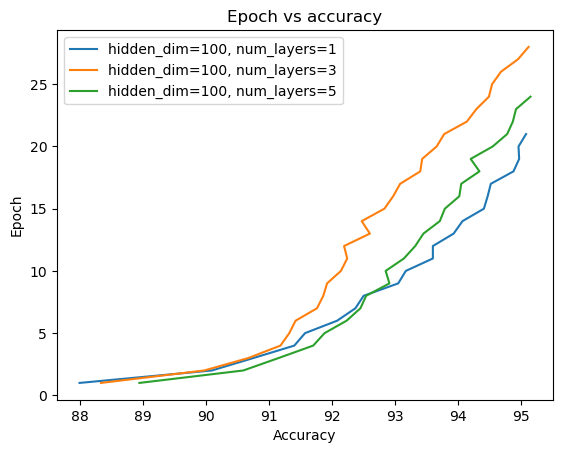

In [5]:
#resnet
import time
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.skip_connection_transform = nn.Linear(input_dim, hidden_dim)  # Transform for skip connection

    def forward(self, x):
        original_input = x  # Store the original input
        for i, layer in enumerate(self.layers[:-1]):  # all layers except last one
            x = self.leaky_relu(layer(x))
            if i % 2 == 0 and i != 0:  # Add skip connection every 2 layers, starting from the second layer
                x += self.skip_connection_transform(original_input)  # Transform and use the original input for the skip connection
        x = self.layers[-1](x)  # last layer without activation
        return x

# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

depth_variations = [1, 3, 5, 7, 9]
lr=0.0001
start_time = time.time()
final_energy_consumptions = []
# Fixed width, vary depth
for num_layers in depth_variations:
    print(f'Training with hidden_dim=100, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, 100, output_dim, num_layers)
    # Move the model to GPU if available
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    cumulative_energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)
        cumulative_energy_consumptions.append(cumulative_energy_consumption)


        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    final_energy_consumptions.append(cumulative_energy_consumption) 
    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim=100, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim=100, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()


plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthaccuracy_over_epochs.png")

plt.figure(3)
plt.semilogy(depth_variations, final_energy_consumptions)
plt.xlabel('Depth')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Depth')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/depth_vs_energy.png")

plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")



Training with hidden_dim=113, num_layers=1
Epoch 1, Accuracy: 88.03%
Epoch 2, Accuracy: 89.92%
Epoch 3, Accuracy: 90.73%
Epoch 4, Accuracy: 91.48%
Epoch 5, Accuracy: 91.55%
Epoch 6, Accuracy: 92.34%
Epoch 7, Accuracy: 92.69%
Epoch 8, Accuracy: 92.43%
Epoch 9, Accuracy: 93.12%
Epoch 10, Accuracy: 93.35%
Epoch 11, Accuracy: 93.76%
Epoch 12, Accuracy: 93.81%
Epoch 13, Accuracy: 94.0%
Epoch 14, Accuracy: 94.43%
Epoch 15, Accuracy: 94.49%
Epoch 16, Accuracy: 94.69%
Epoch 17, Accuracy: 94.93%
Epoch 18, Accuracy: 94.8%
Epoch 19, Accuracy: 95.02%
Epoch 20, Accuracy: 95.32%
Epoch 21, Accuracy: 95.31%
Epoch 22, Accuracy: 95.45%
Epoch 23, Accuracy: 95.5%
Epoch 24, Accuracy: 95.77%
Epoch 25, Accuracy: 95.67%
Epoch 26, Accuracy: 95.84%
Epoch 27, Accuracy: 96.02%
Epoch 28, Accuracy: 95.92%
Epoch 29, Accuracy: 96.11%
Epoch 30, Accuracy: 96.13%
Epoch 31, Accuracy: 96.37%
Epoch 32, Accuracy: 96.29%
Epoch 33, Accuracy: 96.31%
Epoch 34, Accuracy: 96.34%
Epoch 35, Accuracy: 96.43%
Epoch 36, Accuracy: 96.5

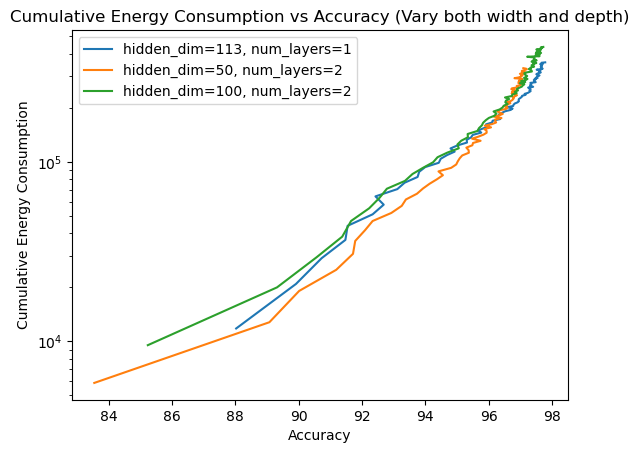

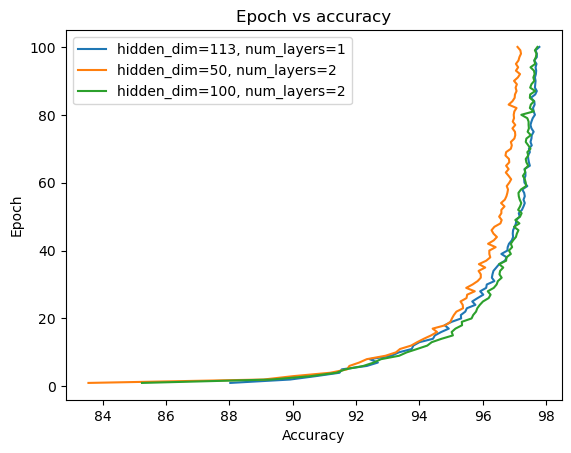

In [4]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x

# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

structure_variations = [(113, 1), (50, 2), (100, 2)]
lr=0.0001

# Vary both width and depth
for hidden_dim, num_layers in structure_variations:
    print(f'Training with hidden_dim={hidden_dim}, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, hidden_dim, output_dim, num_layers)
    # Move the model to GPU if available
    #model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
   
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            #images = images.to(device)
            #labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)
        
        
        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 99:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    
    plt.figure(1)     
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim={hidden_dim}, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Vary both width and depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim={hidden_dim}, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

    

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthandwidth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthandwidthaccuracy_over_epochs.png")
plt.show()


Training with hidden_dim=1120, num_layers=1
Epoch 1, Accuracy: 88.98%
Epoch 2, Accuracy: 90.1%
Epoch 3, Accuracy: 90.95%
Epoch 4, Accuracy: 91.57%
Epoch 5, Accuracy: 92.12%
Epoch 6, Accuracy: 92.52%
Epoch 7, Accuracy: 92.59%
Epoch 8, Accuracy: 92.9%
Epoch 9, Accuracy: 93.23%
Epoch 10, Accuracy: 93.43%
Epoch 11, Accuracy: 93.68%
Epoch 12, Accuracy: 93.89%
Epoch 13, Accuracy: 94.06%
Epoch 14, Accuracy: 94.26%
Epoch 15, Accuracy: 94.44%
Epoch 16, Accuracy: 94.69%
Epoch 17, Accuracy: 94.78%
Epoch 18, Accuracy: 94.86%
Epoch 19, Accuracy: 95.04%
Stopping training after reaching 95.04% accuracy.
Training with hidden_dim=280, num_layers=4
Epoch 1, Accuracy: 40.06%
Epoch 2, Accuracy: 79.18%
Epoch 3, Accuracy: 86.98%
Epoch 4, Accuracy: 89.19%
Epoch 5, Accuracy: 90.59%
Epoch 6, Accuracy: 91.24%
Epoch 7, Accuracy: 91.97%
Epoch 8, Accuracy: 92.57%
Epoch 9, Accuracy: 92.97%
Epoch 10, Accuracy: 93.53%
Epoch 11, Accuracy: 93.95%
Epoch 12, Accuracy: 94.34%
Epoch 13, Accuracy: 94.83%
Epoch 14, Accuracy:

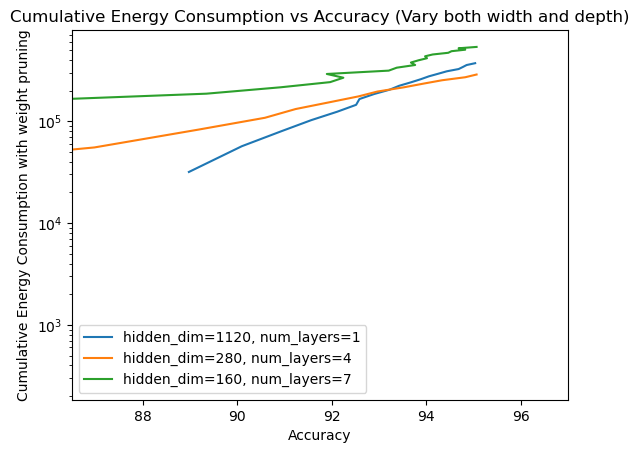

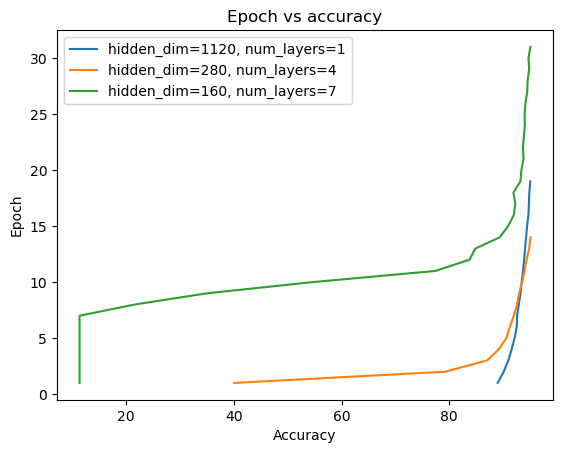

In [9]:
#weight pruning
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x

# Function to prune weights
def prune_weights(model, threshold=0.01):
    for param in model.parameters():
        with torch.no_grad():
            param *= (param.abs() >= threshold).float()

# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

structure_variations = [(1120, 1), (280, 4), (160, 7)]
lr=0.0001

# Vary both width and depth
for hidden_dim, num_layers in structure_variations:
    print(f'Training with hidden_dim={hidden_dim}, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
   
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)
        
        # Prune weights after each epoch
        prune_weights(model, threshold=0.01)
        
        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    
    plt.figure(1)     
    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim={hidden_dim}, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption with weight pruning')
    plt.title('Cumulative Energy Consumption vs Accuracy (Vary both width and depth)')
    plt.xlim(86.5, 97)  # Set the x-axis limits
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'hidden_dim={hidden_dim}, num_layers={num_layers}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

    

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/weightpruning_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/weightpruning_over_epochs.png")
plt.show()


Training with num_blocks=[1, 1, 1, 1]
Epoch 1, Accuracy: 79.15%
Epoch 2, Accuracy: 85.57%
Epoch 3, Accuracy: 87.96%
Epoch 4, Accuracy: 89.22%
Epoch 5, Accuracy: 89.97%
Epoch 6, Accuracy: 90.7%
Epoch 7, Accuracy: 91.26%
Epoch 8, Accuracy: 91.51%
Epoch 9, Accuracy: 91.78%
Epoch 10, Accuracy: 92.05%
Epoch 11, Accuracy: 92.37%
Epoch 12, Accuracy: 92.68%
Epoch 13, Accuracy: 92.79%
Epoch 14, Accuracy: 92.93%
Epoch 15, Accuracy: 93.03%
Epoch 16, Accuracy: 93.12%
Epoch 17, Accuracy: 93.32%
Epoch 18, Accuracy: 93.44%
Epoch 19, Accuracy: 93.56%
Epoch 20, Accuracy: 93.67%
Epoch 21, Accuracy: 93.69%
Epoch 22, Accuracy: 93.66%
Epoch 23, Accuracy: 93.82%
Epoch 24, Accuracy: 93.94%
Epoch 25, Accuracy: 94.05%
Epoch 26, Accuracy: 94.1%
Epoch 27, Accuracy: 94.25%
Epoch 28, Accuracy: 94.28%
Epoch 29, Accuracy: 94.27%
Epoch 30, Accuracy: 94.41%
Epoch 31, Accuracy: 94.44%
Epoch 32, Accuracy: 94.47%
Epoch 33, Accuracy: 94.5%
Epoch 34, Accuracy: 94.56%
Epoch 35, Accuracy: 94.59%
Epoch 36, Accuracy: 94.6%
Epo

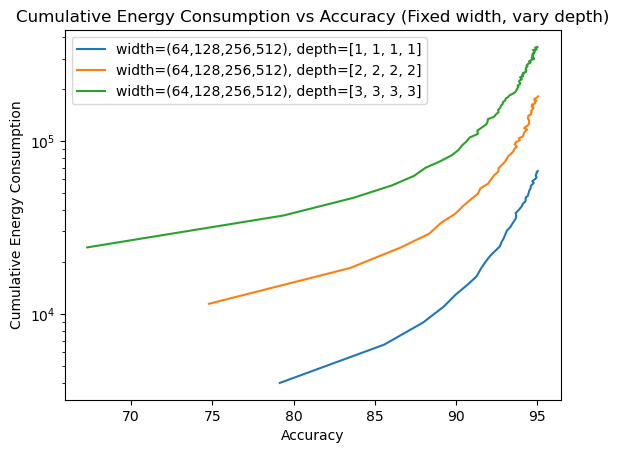

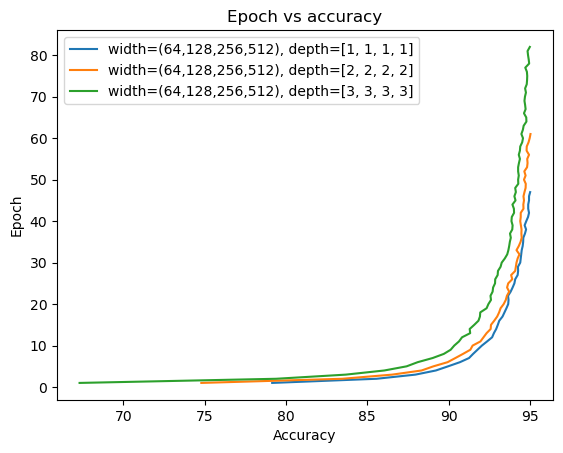

Elapsed time: 6754.653182029724 seconds


In [3]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import time

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Identity shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                nn.BatchNorm1d(out_channels)
            )

        # Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        if stride != 1 or in_channels != out_channels:
            nn.init.xavier_uniform_(self.shortcut[0].weight)

    def forward(self, x):
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, input_size, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer1 = self._make_layer(64, num_blocks[0])
        self.layer2 = self._make_layer(128, num_blocks[1])
        self.layer3 = self._make_layer(256, num_blocks[2])
        self.layer4 = self._make_layer(512, num_blocks[3])
        self.linear = nn.Linear(512, num_classes)

        # Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.linear.weight)

    def _make_layer(self, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
            self.in_channels = out_channels  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.linear(out)
        return out




# Reshape the images to (batch_size, 784)
train_imgs = train_imgs.view(-1, 28*28)
test_imgs = test_imgs.view(-1, 28*28)

# Create data loaders
batch_size = 64
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Instantiate the ResNet with different depth variations
depth_variations = [[1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]]

lr=0.001
start_time = time.time()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Instantiate the ResNet for each depth variation
for num_blocks in depth_variations:
    print(f'Training with num_blocks={num_blocks}')
    model = ResNet(784, num_blocks)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'width=(64,128,256,512), depth={num_blocks}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'width=(64,128,256,512), depth={num_blocks}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/varydepthaccuracy_over_epochs.png")
plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Training with num_blocks=[1, 1, 1, 1]
Epoch 1, Accuracy: 49.55%
Epoch 2, Accuracy: 66.05%
Epoch 3, Accuracy: 73.15%
Epoch 4, Accuracy: 77.68%
Epoch 5, Accuracy: 80.6%
Epoch 6, Accuracy: 82.72%
Epoch 7, Accuracy: 84.3%
Epoch 8, Accuracy: 85.88%
Epoch 9, Accuracy: 87.13%
Epoch 10, Accuracy: 88.26%
Epoch 11, Accuracy: 89.0%
Epoch 12, Accuracy: 89.92%
Epoch 13, Accuracy: 90.81%
Epoch 14, Accuracy: 91.39%
Epoch 15, Accuracy: 91.99%
Epoch 16, Accuracy: 92.57%
Epoch 17, Accuracy: 92.93%
Epoch 18, Accuracy: 93.32%
Epoch 19, Accuracy: 93.58%
Epoch 20, Accuracy: 94.03%
Epoch 21, Accuracy: 94.19%
Epoch 22, Accuracy: 94.44%
Epoch 23, Accuracy: 94.58%
Epoch 24, Accuracy: 94.77%
Epoch 25, Accuracy: 94.98%
Epoch 26, Accuracy: 95.16%
Stopping training after reaching 95.16% accuracy.
Training with num_blocks=[2, 2, 2, 2]
Epoch 1, Accuracy: 61.39%
Epoch 2, Accuracy: 77.3%
Epoch 3, Accuracy: 84.15%
Epoch 4, Accuracy: 87.46%
Epoch 5, Accuracy: 89.49%
Epoch 6, Accuracy: 90.93%
Epoch 7, Accuracy: 92.09%
Epo

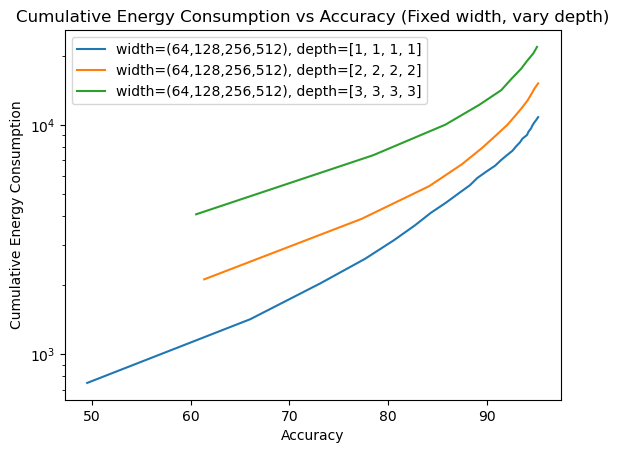

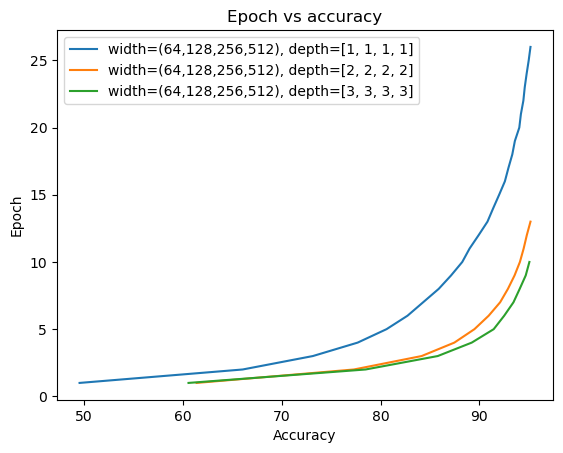

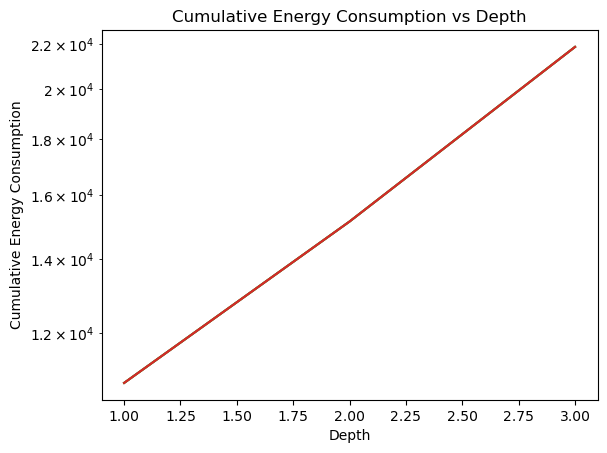

Elapsed time: 3441.3421239852905 seconds


In [4]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import time

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)     #Batch Normalization Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Identity shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        if stride != 1 or in_channels != out_channels:
            nn.init.xavier_uniform_(self.shortcut[0].weight)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.linear.weight)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
# Reshape the images to (batch_size, 1, 28, 28)
train_imgs = train_imgs.view(-1, 1, 28, 28)
test_imgs = test_imgs.view(-1, 1, 28, 28)

# Create data loaders
batch_size = 64
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Instantiate the ResNet with different depth variations
depth_variations = [[1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]]
final_energy_consumptions = []
lr=0.0001
start_time = time.time()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Instantiate the ResNet for each depth variation
for num_blocks in depth_variations:
    print(f'Training with num_blocks={num_blocks}')
    model = ResNet(num_blocks)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break
    final_energy_consumptions.append(cumulative_energy_consumption) 
    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'width=(64,128,256,512), depth={num_blocks}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'width=(64,128,256,512), depth={num_blocks}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/Resvarydepth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/RESvarydepthaccuracy_over_epochs.png")

plt.figure(3)
plt.semilogy(depth_variations, final_energy_consumptions)
plt.xlabel('Depth')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Depth')
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/RESdepth_vs_energy.png")
plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Training with width multiplier=1, depth=[1, 1]
Epoch 1, Accuracy: 45.89%
Epoch 2, Accuracy: 57.39%
Epoch 3, Accuracy: 66.38%
Epoch 4, Accuracy: 73.14%
Epoch 5, Accuracy: 78.54%
Epoch 6, Accuracy: 83.13%
Epoch 7, Accuracy: 86.25%
Epoch 8, Accuracy: 88.63%
Epoch 9, Accuracy: 90.22%
Epoch 10, Accuracy: 91.43%
Epoch 11, Accuracy: 92.51%
Epoch 12, Accuracy: 93.09%
Epoch 13, Accuracy: 93.79%
Epoch 14, Accuracy: 94.41%
Epoch 15, Accuracy: 94.87%
Epoch 16, Accuracy: 95.02%
Stopping training after reaching 95.02% accuracy.
Training with width multiplier=2, depth=[2, 2]
Epoch 1, Accuracy: 81.97%
Epoch 2, Accuracy: 91.53%
Epoch 3, Accuracy: 94.27%
Epoch 4, Accuracy: 95.49%
Stopping training after reaching 95.49% accuracy.


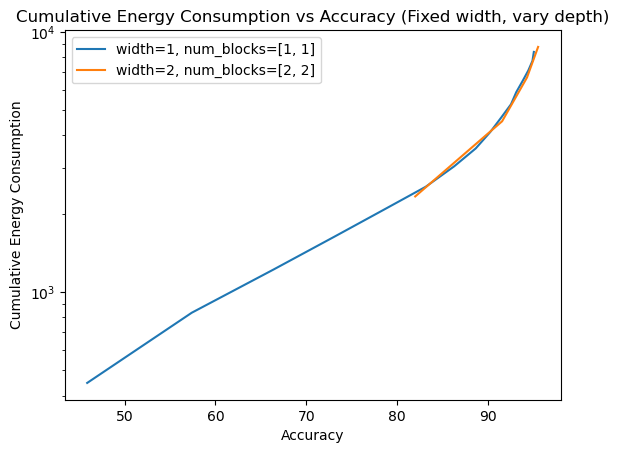

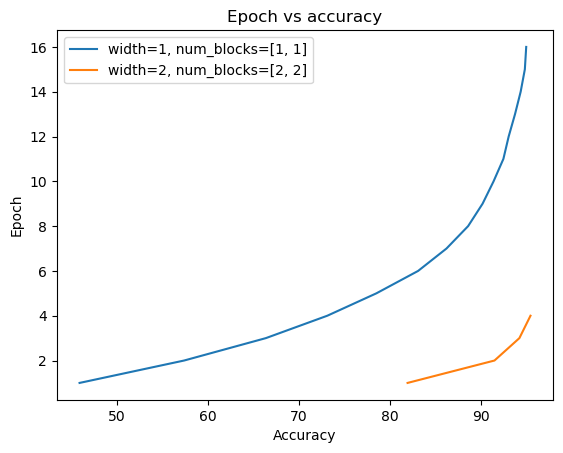

Elapsed time: 1532.4753777980804 seconds


In [5]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import time

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Identity shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        if stride != 1 or in_channels != out_channels:
            nn.init.xavier_uniform_(self.shortcut[0].weight)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, width_multiplication=1, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64 * width_multiplication

        self.conv1 = nn.Conv2d(1, 64 * width_multiplication, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * width_multiplication)
        self.layer1 = self._make_layer(64 * width_multiplication, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128 * width_multiplication, num_blocks[1], stride=1)
        self.linear = nn.Linear(128 * width_multiplication, num_classes)

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.linear.weight)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
# Reshape the images to (batch_size, 1, 28, 28)
train_imgs = train_imgs.view(-1, 1, 28, 28)
test_imgs = test_imgs.view(-1, 1, 28, 28)

# Create data loaders
batch_size = 64
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


width_variations = [1, 2]
depth_variations = [[1, 1], [2, 2]]

lr=0.001
start_time = time.time()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Instantiate the ResNet for each depth variation
for depth, width_mult in zip(depth_variations, width_variations):
    print(f'Training with width multiplier={width_mult}, depth={depth}')
    model = ResNet(depth, width_multiplication=width_mult)  
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.figure(1)
    plt.semilogy(accuracies, energy_consumptions, label=f'width={width_mult}, num_blocks={depth}')
    plt.xlabel('Accuracy')
    plt.ylabel('Cumulative Energy Consumption')
    plt.title('Cumulative Energy Consumption vs Accuracy (Vary depth and width)')
    plt.legend()
    plt.figure(2)
    plt.plot(accuracies, range(1, len(accuracies) + 1), label=f'width={width_mult}, num_blocks={depth}')
    plt.xlabel('Accuracy')
    plt.ylabel('Epoch')
    plt.title('Epoch vs accuracy')
    plt.legend()

plt.figure(1)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/RESvarydepthandwidth_energy_vs_accuracy.png")


plt.figure(2)
plt.savefig("/Users/tim/Desktop/postgraduate/research project/STUDY/diagram/RESvarydepthandwidthaccuracy_over_epochs.png")
plt.show()



end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
